In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from glob import glob
import os

from genotyping import nucleotide_mutation_prob, mutation_prob, COUNTS_COLUMNS


# Plotting style
sns.set_style('white')
sns.set_context('notebook')
#pd.set_option('max_rows', 1000)
#pd.set_option('max_columns', 100)

def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']


# Load reference

In [4]:
reference_path = '../../../data/reference/mito_GRCh38_gimlet.fasta'

with open(reference_path, 'r'):
    reference_seq = next(SeqIO.parse(reference_path, "fasta"))
reference = pd.Series(list(reference_seq.seq))

# Load count data

In [36]:
INPUT_PATH = '/home/carler/lab/t_cell/phylogeny/data/ac_input/'
OUTPUT_PATH = '/home/carler/lab/t_cell/phylogeny/data/data_vizsualiation/'
e_rate = 0.0556
p_mutation = 1 / 500.0


In [7]:
datasets = ['A1_06', 'A1_30']

meta_data = pd.read_csv('/home/carler/lab/t_cell/meta_data/2023_04_06_A1_06_A1_30_YFV2003_JH_meta_data_invivo_t_cell_mito_project.csv', index_col=0)

clone_n_10 = meta_data.groupby('clone_id')['Donor'].count()
clone_n_10 = pd.DataFrame(clone_n_10[clone_n_10 >= 10]) 
meta_data_clone_n_10 = meta_data.loc[meta_data['clone_id'].isin(clone_n_10.loc[clone_n_10.index.str[1] != '-'].sort_values('Donor').index)] 
cell_count = {'A1_06' : [],
              'A1_30' : [], 
              'YFV2003': [], 
              'JH': []}

# Get all allele counts files in the input path
cell_count_filenames = list(glob(os.path.join(INPUT_PATH, '*.t*'))) #*.txt/.tsv




sample_list = {'A1_06' : [],
              'A1_30' : [], 
              'YFV2003': [], 
              'JH': []}

#for filename in sorted(cell_count_filenames):
#    name = os.path.basename(filename).split('-')[0]#.split('_')[-1]
#    sample_list.append(name)




for filename in sorted(cell_count_filenames):
    #print('Reading {}'.format(filename))
    name = os.path.basename(filename).split('.')[0]
    
    if  name not in meta_data_clone_n_10.index: 
        continue
    
    # Load one allele count file
    counts = pd.read_csv(filename, sep='\t')
    counts = pd.DataFrame(index=range(1, 16572, 1), columns=['#CHR', 'Count_A', 'Count_C', 'Count_G', 'Count_T', 'Good_depth']).combine_first(counts.set_index('POS')).fillna(0)
    counts[['Count_A', 'Count_C', 'Count_G', 'Count_T', 'Good_depth']] = counts[['Count_A', 'Count_C', 'Count_G', 'Count_T', 'Good_depth']].astype(int)
    counts.index.name = 'POS'
    counts = counts.reset_index()
    counts.name = name
    try: 
        cell_count[meta_data.loc[name].Donor].append(counts)
        sample_list[meta_data.loc[name].Donor].append(name)
    except KeyError: 
        continue

# Get sample order
'''
sample_list = {'A1_06' : [],
              'A1_30' : [], 
              'YFV2003': [], 
              'JH': []}

for filename in sorted(cell_count_filenames):
    name = os.path.basename(filename).split('-')[0]#.split('_')[-1]
    sample_list[meta_data.loc[name[:-4]].Donor].append(name)

sample_list_df = {'A1_06' : [],
              'A1_30' : [], 
              'YFV2003': [], 
              'JH': []}

for donor in datasets: 
    sample_list_df[donor] = pd.DataFrame(sample_list[donor])
    sample_list_df[donor] = sample_list_df[donor].rename(columns={0: 'cell'})'''

"\nsample_list = {'A1_06' : [],\n              'A1_30' : [], \n              'YFV2003': [], \n              'JH': []}\n\nfor filename in sorted(cell_count_filenames):\n    name = os.path.basename(filename).split('-')[0]#.split('_')[-1]\n    sample_list[meta_data.loc[name[:-4]].Donor].append(name)\n\nsample_list_df = {'A1_06' : [],\n              'A1_30' : [], \n              'YFV2003': [], \n              'JH': []}\n\nfor donor in datasets: \n    sample_list_df[donor] = pd.DataFrame(sample_list[donor])\n    sample_list_df[donor] = sample_list_df[donor].rename(columns={0: 'cell'})"

# Build reads count matrix

In [8]:
reads_per_cell = {'A1_06': [],
                  'A1_30': []}
for donor in datasets: 
    for count in cell_count[donor]:
        reads = count[COUNTS_COLUMNS].sum(axis=1)
        reads_per_cell[donor].append(reads)


In [11]:
reads_matrix = {'A1_06': [],
                'A1_30': []}
for donor in datasets: 
    reads_matrix[donor] = cell_count[donor][0][['POS']].copy()
    reads_matrix_data = pd.concat(reads_per_cell[donor], axis=1)
    reads_matrix_data.columns = sample_list[donor]
    reads_matrix[donor] = pd.concat([reads_matrix[donor], reads_matrix_data], axis=1).set_index('POS')

In [15]:
for donor in datasets:
    print(reads_matrix[donor].shape) 

(16571, 1471)
(16571, 1023)


In [16]:
reads_matrix['A1_06'].head()

,A1_06_D14_p1_A14,A1_06_D14_p1_A15,A1_06_D14_p1_A16,A1_06_D14_p1_A21,A1_06_D14_p1_A22,A1_06_D14_p1_A23,A1_06_D14_p1_A4,A1_06_D14_p1_A5,A1_06_D14_p1_A9,A1_06_D14_p1_B1,...,A1_06_D180_p5_O4,A1_06_D180_p5_O5,A1_06_D180_p5_O6,A1_06_D180_p5_P15,A1_06_D180_p5_P16,A1_06_D180_p5_P17,A1_06_D180_p5_P18,A1_06_D180_p5_P21,A1_06_D180_p5_P3,A1_06_D180_p5_P6
POS,,,,,,,,,,,,,,,,,,,,,
1,1,1,0,0,20,0,4,0,0,1,...,24,2,0,0,0,0,21,0,0,6
2,1,1,0,0,19,0,5,0,0,1,...,24,2,0,0,0,0,22,0,0,6
3,1,1,0,0,20,0,5,0,0,1,...,25,3,0,0,0,0,23,0,0,6
4,1,1,0,0,20,0,5,0,0,1,...,25,3,0,0,0,0,23,0,0,6
5,1,1,0,0,19,0,5,0,0,1,...,25,3,0,0,0,0,23,0,0,6


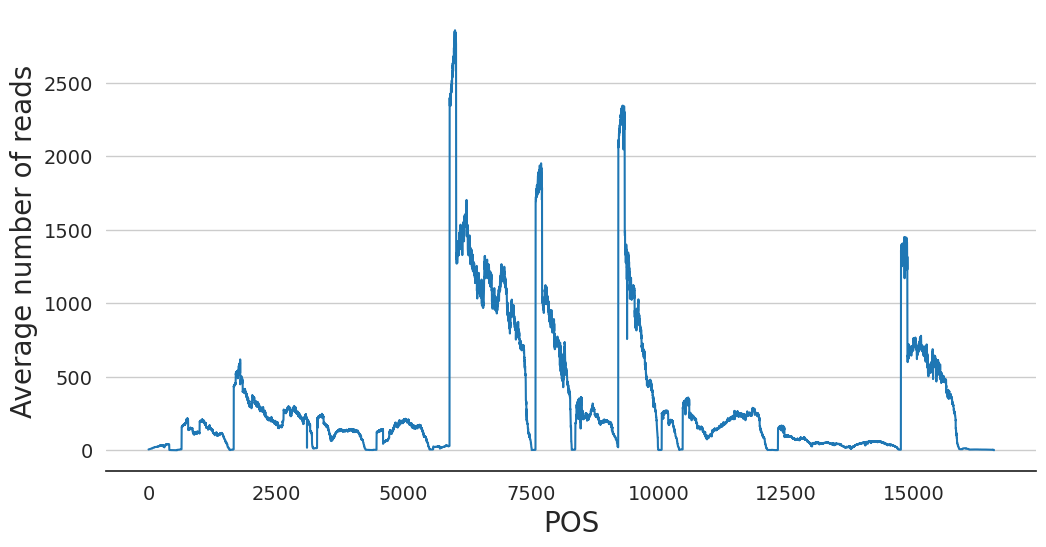

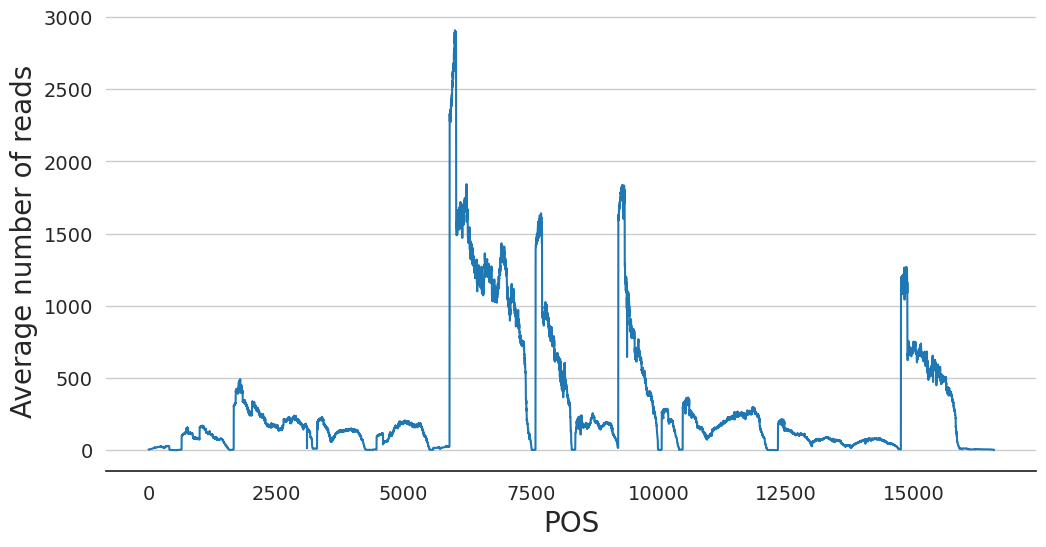

In [18]:
for donor in datasets: 
    with plot_style():
        plt.figure()
        reads_matrix[donor].mean(axis=1).plot()
        plt.grid(axis='y')
        plt.ylabel('Average number of reads')

<Figure size 1200x600 with 0 Axes>

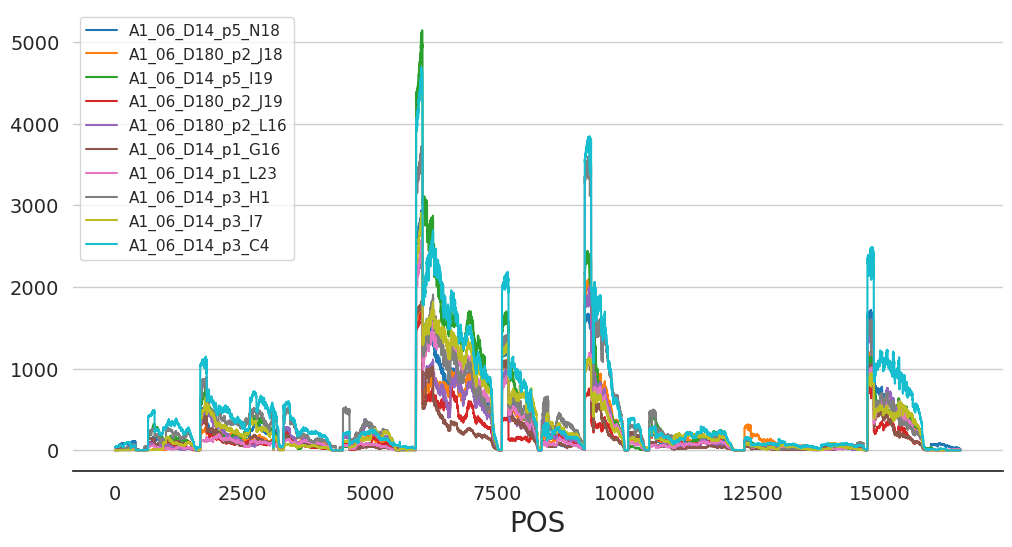

<Figure size 1200x600 with 0 Axes>

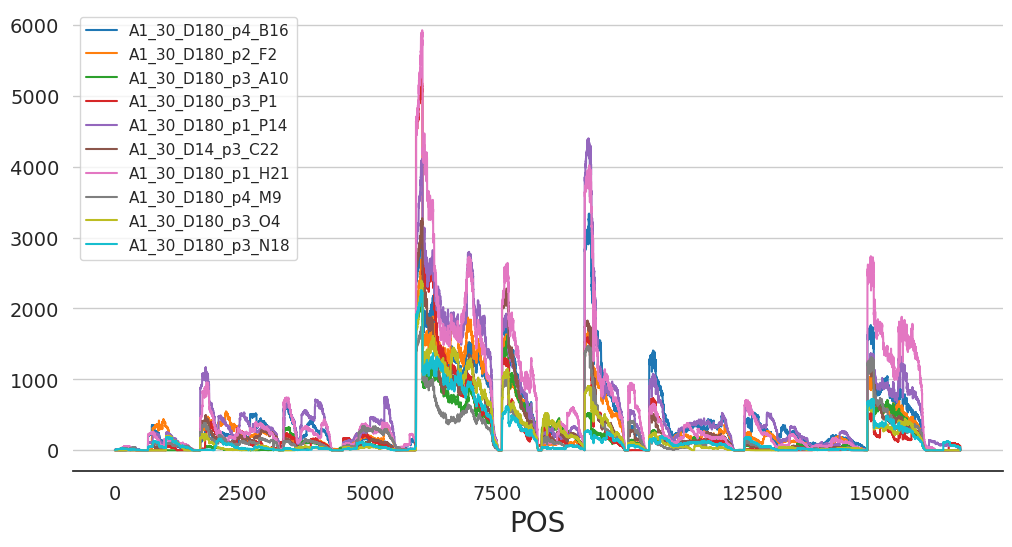

In [20]:
for donor in datasets: 
    with plot_style():
        plt.figure()
        reads_matrix[donor].sample(10, axis=1).plot()
        plt.grid(axis='y')

# Mutation matrix pmat

In [22]:
error_rate_when_no_mutation = error_rate_when_mutation = e_rate


cell_prob = {'A1_06': [],
             'A1_30': []}
for donor in datasets: 
    for count in cell_count[donor]:
        count = count.iloc[:reference.shape[0]]  # discard trailing positions
        p = nucleotide_mutation_prob(
            cell_counts=count,
            reference=reference,
            error_rate_when_no_mutation=error_rate_when_no_mutation,
            error_rate_when_mutation=error_rate_when_mutation,
            p_mutation=p_mutation,
        )

        cell_prob[donor].append(p)
    

In [23]:
# Compute P(mutation | read counts)
cells_p_mutation = {'A1_06': [],
                    'A1_30': []}
for donor in datasets:

    for idx, cp in enumerate(cell_prob[donor]):
        if cp.shape[0] != reference.shape[0]:
            print('Discarding ')
        p = mutation_prob(cp, reference)
        cells_p_mutation[donor].append(p)



/home/carler/lab/t_cell/phylogeny/MCMT/Notebooks/A1_06_A1_30_YFV2003_JH/genotyping.py:240: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  prob_mutation['Prob_mutation'] = 1 - p.lookup(p.index, reference.values)
/home/carler/lab/t_cell/phylogeny/MCMT/Notebooks/A1_06_A1_30_YFV2003_JH/genotyping.py:240: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  prob_mutation['Prob_mutation'] = 1 - p.lookup(p.index, reference.values)
/home/carler/lab/t_cell/phylogeny/MCMT/Notebooks/A1_06_A1_30_YFV2003_JH/genotyping.py:240: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  prob_mutation['Prob_mutation'] = 1 - p.lookup(p.index, reference.values)
/home/carler/lab/t_cell/phylogeny/MCMT/Noteboo

In [25]:
# Mutation matrix
mutation_matrix = {'A1_06': [],
                   'A1_30': []}
for donor in datasets: 
    mutation_matrix[donor] = cells_p_mutation[donor][0][['POS']].copy()
    mutation_matrix_data = pd.DataFrame(np.dstack([c['Prob_mutation'].values for c in cells_p_mutation[donor]]).squeeze())
    mutation_matrix_data.columns = sample_list[donor]
    mutation_matrix[donor] = pd.concat([mutation_matrix[donor], mutation_matrix_data], axis=1).set_index('POS')


In [26]:
mutation_matrix['A1_06'].shape

(16569, 1471)

In [28]:
mutation_matrix['A1_06'].head()

,A1_06_D14_p1_A14,A1_06_D14_p1_A15,A1_06_D14_p1_A16,A1_06_D14_p1_A21,A1_06_D14_p1_A22,A1_06_D14_p1_A23,A1_06_D14_p1_A4,A1_06_D14_p1_A5,A1_06_D14_p1_A9,A1_06_D14_p1_B1,...,A1_06_D180_p5_O4,A1_06_D180_p5_O5,A1_06_D180_p5_O6,A1_06_D180_p5_P15,A1_06_D180_p5_P16,A1_06_D180_p5_P17,A1_06_D180_p5_P18,A1_06_D180_p5_P21,A1_06_D180_p5_P3,A1_06_D180_p5_P6
POS,,,,,,,,,,,,,,,,,,,,,
1,0.002,0.002,NaN,NaN,0.000100,NaN,0.000501,NaN,NaN,0.002,...,0.000083,0.001001,NaN,NaN,NaN,NaN,0.000095,NaN,NaN,0.000334
2,0.002,0.002,NaN,NaN,0.000105,NaN,0.000401,NaN,NaN,0.002,...,0.000083,0.001001,NaN,NaN,NaN,NaN,0.000091,NaN,NaN,0.000334
3,0.002,0.002,NaN,NaN,0.000100,NaN,0.000401,NaN,NaN,0.002,...,0.000080,0.000668,NaN,NaN,NaN,NaN,0.000087,NaN,NaN,0.000334
4,0.002,0.002,NaN,NaN,0.000100,NaN,0.000401,NaN,NaN,0.002,...,0.000080,0.000668,NaN,NaN,NaN,NaN,0.000087,NaN,NaN,0.000334
5,0.002,0.002,NaN,NaN,0.000105,NaN,0.000401,NaN,NaN,0.002,...,0.000080,0.000668,NaN,NaN,NaN,NaN,0.000087,NaN,NaN,0.000334


<Figure size 1200x600 with 0 Axes>

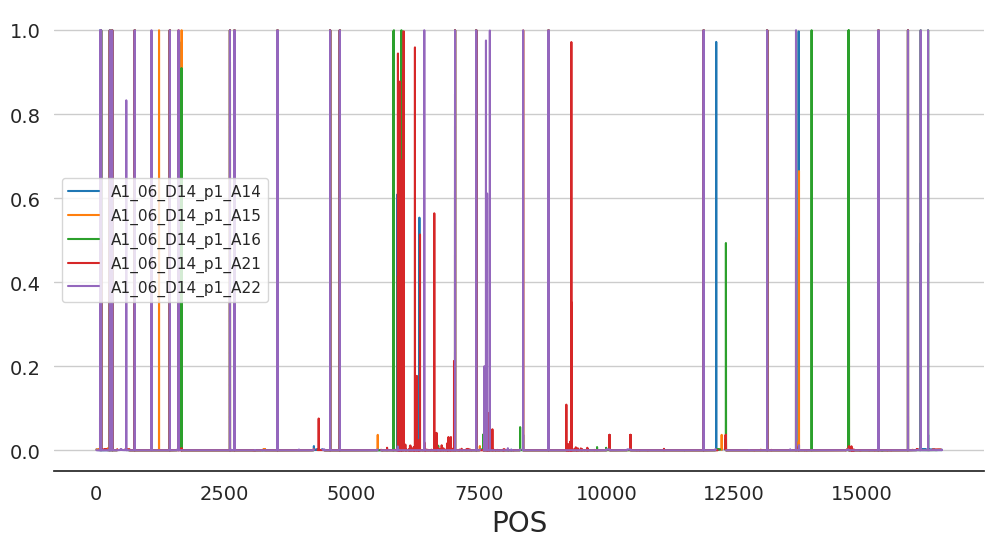

<Figure size 1200x600 with 0 Axes>

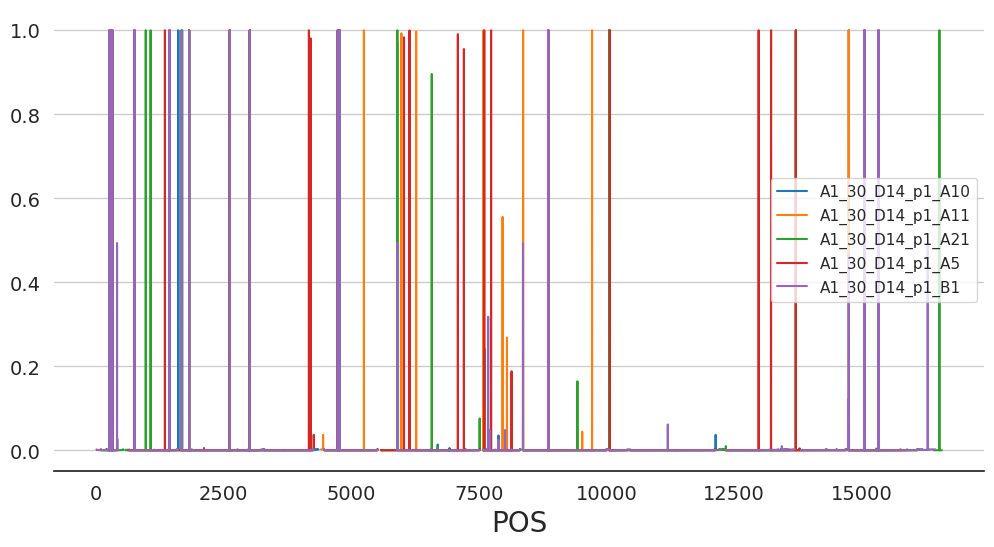

In [29]:
for donor in datasets: 
    with plot_style():
        plt.figure()
        mutation_matrix[donor].iloc[:, :5].plot()
        plt.grid(axis='y')

# Save matrices

In [30]:
e_rate

0.0556

In [37]:
RESULTS_PATH = f'{OUTPUT_PATH}/results'

In [38]:
for donor in datasets: 
    reads_matrix[donor].to_csv(f'{RESULTS_PATH}/{donor}_reads_{e_rate}.csv', index=True)

In [40]:
for donor in datasets: 
    mutation_matrix[donor].to_csv(f'{RESULTS_PATH}/{donor}_pmat_{e_rate}.csv', index=True)

In [22]:
mutation_matrix.head()

,P20407_A6_D14_p1_A1,P20407_A6_D14_p1_A10,P20407_A6_D14_p1_A11,P20407_A6_D14_p1_A12,P20407_A6_D14_p1_A13,P20407_A6_D14_p1_A14,P20407_A6_D14_p1_A15,P20407_A6_D14_p1_A16,P20407_A6_D14_p1_A18,P20407_A6_D14_p1_A2,P20407_A6_D14_p1_A21,P20407_A6_D14_p1_A22,P20407_A6_D14_p1_A23,P20407_A6_D14_p1_A24,P20407_A6_D14_p1_A3,P20407_A6_D14_p1_A4,P20407_A6_D14_p1_A5,P20407_A6_D14_p1_A7,P20407_A6_D14_p1_A9,P20407_A6_D14_p1_B1,P20407_A6_D14_p1_B10,P20407_A6_D14_p1_B11,P20407_A6_D14_p1_B13,P20407_A6_D14_p1_B14,P20407_A6_D14_p1_B15,P20407_A6_D14_p1_B16,P20407_A6_D14_p1_B17,P20407_A6_D14_p1_B18,P20407_A6_D14_p1_B19,P20407_A6_D14_p1_B20,P20407_A6_D14_p1_B21,P20407_A6_D14_p1_B22,P20407_A6_D14_p1_B23,P20407_A6_D14_p1_B3,P20407_A6_D14_p1_B4,P20407_A6_D14_p1_B5,P20407_A6_D14_p1_B6,P20407_A6_D14_p1_B7,P20407_A6_D14_p1_B8,P20407_A6_D14_p1_B9,P20407_A6_D14_p1_C1,P20407_A6_D14_p1_C12,P20407_A6_D14_p1_C14,P20407_A6_D14_p1_C15,P20407_A6_D14_p1_C16,P20407_A6_D14_p1_C17,P20407_A6_D14_p1_C19,P20407_A6_D14_p1_C2,P20407_A6_D14_p1_C20,P20407_A6_D14_p1_C22,...,P20407_A6_D180_p5_N24,P20407_A6_D180_p5_N3,P20407_A6_D180_p5_N4,P20407_A6_D180_p5_N5,P20407_A6_D180_p5_N6,P20407_A6_D180_p5_N7,P20407_A6_D180_p5_N8,P20407_A6_D180_p5_N9,P20407_A6_D180_p5_O1,P20407_A6_D180_p5_O10,P20407_A6_D180_p5_O11,P20407_A6_D180_p5_O12,P20407_A6_D180_p5_O13,P20407_A6_D180_p5_O14,P20407_A6_D180_p5_O15,P20407_A6_D180_p5_O16,P20407_A6_D180_p5_O17,P20407_A6_D180_p5_O19,P20407_A6_D180_p5_O20,P20407_A6_D180_p5_O21,P20407_A6_D180_p5_O22,P20407_A6_D180_p5_O23,P20407_A6_D180_p5_O24,P20407_A6_D180_p5_O3,P20407_A6_D180_p5_O4,P20407_A6_D180_p5_O5,P20407_A6_D180_p5_O6,P20407_A6_D180_p5_O7,P20407_A6_D180_p5_O8,P20407_A6_D180_p5_O9,P20407_A6_D180_p5_P10,P20407_A6_D180_p5_P11,P20407_A6_D180_p5_P12,P20407_A6_D180_p5_P13,P20407_A6_D180_p5_P14,P20407_A6_D180_p5_P15,P20407_A6_D180_p5_P16,P20407_A6_D180_p5_P17,P20407_A6_D180_p5_P18,P20407_A6_D180_p5_P19,P20407_A6_D180_p5_P2,P20407_A6_D180_p5_P20,P20407_A6_D180_p5_P21,P20407_A6_D180_p5_P22,P20407_A6_D180_p5_P3,P20407_A6_D180_p5_P4,P20407_A6_D180_p5_P6,P20407_A6_D180_p5_P7,P20407_A6_D180_p5_P8,P20407_A6_D180_p5_P9
POS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,0.000223,0.000200,0.000668,0.000167,0.002,0.002,NaN,NaN,0.002,NaN,0.000105,NaN,0.000111,0.002,0.000501,NaN,NaN,NaN,NaN,0.002,0.000182,0.000200,NaN,NaN,0.000200,NaN,NaN,NaN,0.001001,NaN,NaN,NaN,NaN,0.000668,0.000200,0.000668,NaN,0.002000,0.0002,NaN,0.000668,NaN,NaN,0.000167,NaN,0.00025,NaN,0.000250,0.002,...,NaN,0.000105,NaN,0.001001,NaN,0.000095,NaN,0.001001,NaN,0.000334,0.000334,0.000118,0.000223,NaN,0.000668,0.000182,0.002,0.000250,0.002000,NaN,0.002,NaN,NaN,0.000501,0.000091,0.001001,NaN,NaN,0.000083,NaN,NaN,NaN,NaN,NaN,0.000334,NaN,NaN,NaN,0.000100,NaN,0.000334,0.001001,NaN,0.000501,NaN,NaN,0.000334,0.000668,NaN,NaN
2,NaN,0.000223,0.000200,0.000668,0.000167,0.002,0.002,NaN,NaN,0.002,NaN,0.000111,NaN,0.000134,0.002,0.000401,NaN,NaN,NaN,NaN,0.002,0.000182,0.000182,NaN,NaN,0.000182,NaN,NaN,NaN,0.001001,NaN,NaN,NaN,NaN,0.000668,0.000200,0.000668,NaN,0.001001,0.0002,NaN,0.000668,NaN,NaN,0.000167,NaN,0.00025,NaN,0.000250,0.002,...,NaN,0.000095,NaN,0.001001,NaN,0.000095,NaN,0.001001,NaN,0.000334,0.000286,0.000118,0.000223,NaN,0.000668,0.000167,0.002,0.000250,0.001001,NaN,0.002,NaN,NaN,0.000401,0.000091,0.001001,NaN,NaN,0.000083,NaN,NaN,NaN,NaN,NaN,0.000401,NaN,NaN,NaN,0.000100,NaN,0.000334,0.001001,NaN,0.000501,NaN,NaN,0.000334,0.000668,NaN,NaN
3,NaN,0.000200,0.000223,0.000668,0.000167,0.002,0.002,NaN,NaN,0.002,NaN,0.000105,NaN,0.000111,0.002,0.000401,NaN,NaN,NaN,NaN,0.002,0.000182,0.000182,NaN,NaN,0.000200,NaN,NaN,NaN,0.001001,NaN,NaN,NaN,NaN,0.000401,0.000250,0.000668,NaN,0.001001,0.0002,NaN,0.000668,NaN,NaN,0.000167,NaN,0.00025,NaN,0.000250,0.002,...,NaN,0.000091,NaN,0.001001,NaN,0.000095,NaN,0.001001,NaN,0.000401,0.000286,0.000118,0.000223,NaN,0.000668,0.000167,0.002,0.000250,0.001001,NaN,0.002,NaN,NaN,0.000401,0.000087,0.000668,NaN,NaN,0.000

# Metadata for the cells in the mutation matrix

In [23]:
metadata = pd.read_csv(f'{BASE_PATH}/{DATA_NAME}_metadata_11082021.tsv')

In [24]:
metadata.head()

,cell_id,mem_score,clone_id,day
0,P20407_A6_D14_p3_M3,-0.130174,116.0,14
1,P20407_A6_D14_p3_K3,-0.165281,831.0,14
2,P20407_A6_D14_p3_P3,0.223043,915.0,14
3,P20407_A6_D14_p3_A3,-0.321243,61.0,14
4,P20407_A6_D14_p3_E3,0.150148,1029.0,14
